## Generating a synthetic healthcare dataset

This notebook will go through the steps of creating a very simplistic (and therefore unrealistic!) model to generate a synthetic dataset, where each row represents a simulated "person", for illustrative purposes.

While several sophisticated and powerful tools (e.g. numpyro, Stan) exist for creating models in Python, here we will try to do something simple and understandable using nothing more than `pandas`, `numpy`, and the built-in `random` library.


In [2]:
import random
import uuid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### NHS ID

This one is easy - we'll just make up a unique string using the "uuid" library.   The first 16 characters of the string will be more than enough to essentially guarantee uniqueness among tens of thousands of rows.

In [3]:
def get_nhs_id():
    return str(uuid.uuid4())[:16]

### Age profile

One of the main inputs we will use for our generative model is some data on the age profile in the UK, taken from the [2011 Census](https://webarchive.nationalarchives.gov.uk/ukgwa/20160105160709/http://www.ons.gov.uk/ons/rel/census/2011-census/population-and-household-estimates-for-the-united-kingdom/rft-table-3-census-2011.xls)

We have copied a simple version of this data, using 5-year bands, into a csv, and just for the sake of convenience we have replaced the label for "90+" with "90-100" (so we can parse the labels later on to get date ranges.

Let's read this csv into Pandas:

In [4]:
df_age_profile = pd.read_csv("age_profile_uk.csv")
df_age_profile

,age_range,pop_frac
0,0-4,0.062
1,5-9,0.056
2,10-14,0.058
3,15-19,0.063
4,20-24,0.068
5,25-29,0.068
6,30-34,0.065
7,35-39,0.066
8,40-44,0.073
9,45-49,0.073


Let's just have a quick check to see what it looks like:

<BarContainer object of 19 artists>

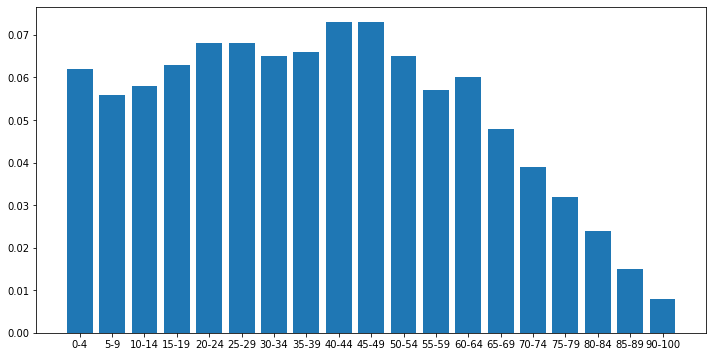

In [5]:
fig=plt.figure(figsize=(12,6))
plt.bar(x=df_age_profile["age_range"],height=df_age_profile["pop_frac"])

### How to use this to generate age values

Since the population fractions in each bin are normalised (the total adds up to 1), we can use the cumulative sum, along with a uniform random distribution between 0 and 1, to generate new values from this distribution.

First we add a column to the dataframe containing the cumulative sum:

<BarContainer object of 19 artists>

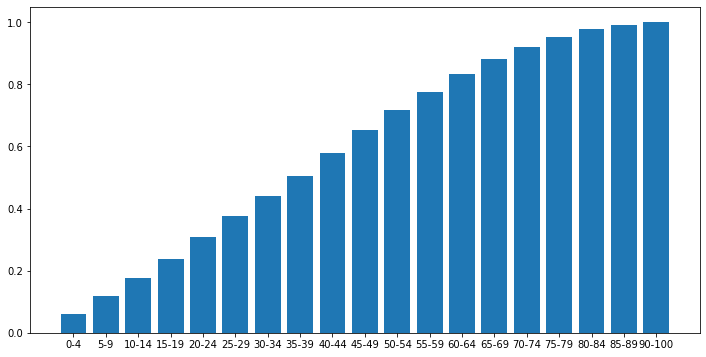

In [6]:
df_age_profile["cumulative_frac"] = df_age_profile["pop_frac"].cumsum()
fig=plt.figure(figsize=(12,6))
plt.bar(x=df_age_profile["age_range"],height=df_age_profile["cumulative_frac"])

Now, if we imagine picking a random number between 0 and 1, finding that value on the y=axis in the above plot, then tracing across to find which bin it is in, we get a 5-year range for our generated age.

For simplicity, we can then pick a random integer from that 5-year range, and return that (note that we are oversimplifying here - ignoring the variation within the 5-year-band).

In [7]:
def get_age(df):
    # generate a random number between 0 and 1
    x = random.random()
    # Highly inefficient way of finding which row of the dataframe
    # has that x value in the cumulative sum range.
    for i in range(len(df)):
        if i == 0 and x < df.iloc[i]["cumulative_frac"]:
            break
        elif x > df.iloc[i-1]["cumulative_frac"] and x < df.iloc[i]["cumulative_frac"]:
            break
    # Now we know the row number "i" - pick an age from that 5-yr range
    #    we have the "age_range" label as a string, e.g. "0-4" - first
    #    split on the dash to get lower and upper bounds
    age_range = df.iloc[i]["age_range"].split("-")
    # Now use "randint" to choose an age (note that lower and upper bounds
    # are inclusive here)
    age = random.randint(int(age_range[0]), int(age_range[1]))
    return age
    
            

Let's just check that this function is doing something sensible - generate 1000 ages and plot them as a histogram:

(array([46., 48., 74., 61., 65., 58., 57., 66., 66., 71., 78., 65., 65.,
        65., 46., 27., 19., 17.,  2.,  4.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <BarContainer object of 20 artists>)

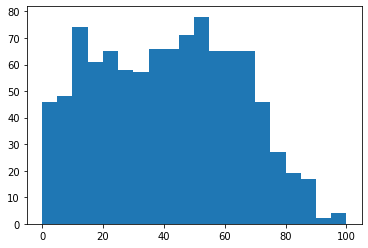

In [8]:
ages = []
for _ in range(1000):
    ages.append(get_age(df_age_profile))
plt.hist(ages,bins=20,range=(0,100))

OK, that looks reasonable.   
Let's move on.


## Generating ethnicity

We will use exactly the same approach to generate the ethnicity of our simulated people.  We have a csv file containing the ethnicity breakdown of the UK population from the UK Census in 2011, obtained from [here]( https://www.ethnicity-facts-figures.service.gov.uk/uk-population-by-ethnicity/national-and-regional-populations/population-of-england-and-wales/latest /)

In [9]:
df_ethnicity = pd.read_csv("by-ethnicity-table.csv")
df_ethnicity

,Ethnicity,Number,%
0,All,"56,075,912",100.0
1,Asian,"4,213,531",7.5
2,Bangladeshi,"447,201",0.8
3,Chinese,"393,141",0.7
4,Indian,"1,412,958",2.5
5,Pakistani,"1,124,511",2.0
6,Asian other,"835,720",1.5
7,Black,"1,864,890",3.3
8,Black African,"989,628",1.8
9,Black Caribbean,"594,825",1.1


We can see that we have a bit more work to do - the percentages don't add up to 100, as we have "summary" categories ("All", "Asian", ...) as well as the finer-grained categories.

We can filter these out into summary and detailed dataframes, depending on what we want to use later on:

In [10]:
mask_summary = (df_ethnicity["Ethnicity"] == "Asian") \
    | (df_ethnicity["Ethnicity"] == "Black") \
    | (df_ethnicity["Ethnicity"] == "Mixed") \
    | (df_ethnicity["Ethnicity"] == "White") \
    | (df_ethnicity["Ethnicity"] == "Other") 
mask_detail = (df_ethnicity["Ethnicity"] != "All") \
    & (df_ethnicity["Ethnicity"] != "Asian") \
    & (df_ethnicity["Ethnicity"] != "Black") \
    & (df_ethnicity["Ethnicity"] != "Mixed") \
    & (df_ethnicity["Ethnicity"] != "White") \
    & (df_ethnicity["Ethnicity"] != "Other") 
df_eth_summary = df_ethnicity.loc[mask_summary, ("Ethnicity","%")]
df_eth_detail = df_ethnicity.loc[mask_detail, ("Ethnicity","%") ]

df_eth_summary["cumulative_frac"] = df_eth_summary["%"].cumsum() / 100
df_eth_detail["cumulative_frac"] = df_eth_detail["%"].cumsum() / 100

Let's write a function to generate an ethnicity (will work with either dataframe), based on the same cumulative sum, as before:

In [11]:
def get_ethnicity(df):
    # generate a random number between 0 and 1
    x = random.random()
    # Highly inefficient way of finding which row of the dataframe
    # has that x value in the cumulative sum range.
    for i in range(len(df)):
        if i == 0 and x < df.iloc[i]["cumulative_frac"]:
            break
        elif x > df.iloc[i-1]["cumulative_frac"] and x < df.iloc[i]["cumulative_frac"]:
            break   
    return df.iloc[i]["Ethnicity"]



## Generating other variables

We will do the simplest possible method for generating the gender of our simulated people - just pick a random number:

In [12]:
def get_gender():
    x = random.random()
    if x < 0.48:
        return "M"
    elif x < 0.96:
        return "F"
    else: 
        return "null"

For height and weight, we will assume Gaussian distributions of height and BMI (BMI is height (in m) divided by weight (in kg) squared), with sex-dependent means and standard deviations.
The mean and standard deviations in height are taken from ["restore", here](https://www.restore.ac.uk/srme/www/fac/soc/wie/research-new/srme/modules/mod1/8/index.html) while those for BMI are estimates based on the values provided by [statistica, here](https://www.statista.com/statistics/375886/adult-s-body-mass-index-by-gender-and-age-in-england/).

We then do some purely ad-hoc corrections to these values to account for age.  We estimate that babies are about 0.5m tall on average, with average BMI of 23.
For height, we assume a linear relation between average height and age from the ages 0-16, then flat afterwards, while for BMI we assume a two-sided linear relation between BMI and age, with the maximum value at age 60.

These assumptions and guesses give us means and standard deviations for Gaussians, depending on age and sex.  We can then use `random.gauss` to draw from these Gaussians and get a height and BMI for a simulated person, then use these to calculate weight.

In [13]:
def get_height_weight(age, sex):
    # if sex is given as "null", assign a 50/50 chance to treating  
    # as "M" or "F" for the purpose of height/weight generation
    if sex == "null":
        sex = "F" if random.random() < 0.5 else "M" 
    # assume linear growth from 0.5m to avg between ages of 0 and 16
    avg_height = 1.78 if sex=="M" else 1.63
    std_height = 0.07 if sex=="M" else 0.06
    if age < 16:
        avg_height = 0.5 + (avg_height-0.5)*age/16
    height = random.gauss(avg_height, std_height)
    # BMI tends to peak at age 60 and is similar for men and women.
    # Take _very_ simplified model where we take max_avg_bmi to be 29
    # at age 60, and min_avg_bmi to be 23 at 60 years away from this,
    # and linearly interpolate between
    avg_bmi_max = 29
    avg_bmi_min = 23
    avg_bmi = abs(60-age)*(avg_bmi_max-avg_bmi_min)/60 + avg_bmi_min
    std_bmi = 6.1 if sex=="F" else 4.7
    bmi = random.gauss(avg_bmi, std_bmi)
    # calculate weight from height and bmi
    weight = bmi * height*height
    return height, weight
    

## Putting it all together

We're now ready to generate some simulated people.  We first get the age, then the sex, then use these to get a height and weight, using the functions defined above.  Each simulated person will be returned as a JSON object, which we can then accumulate into a pandas dataframe.

In [14]:
def generate_person(df_age, df_ethnicity):
    """
    Generate characteristics of a simulated person, and return as JSON
    
    parameter: df: pd.DataFrame, the age profile (including cumulative sum)
    returns: JSON object containing all generated parameters.
    """
    nhs_id = get_nhs_id()
    age = get_age(df_age)
    ethnicity = get_ethnicity(df_ethnicity)
    gender = get_gender()
    height, weight = get_height_weight(age, gender)
    return {
        "nhs_id": nhs_id, 
        "age": age, 
        "gender": gender, 
        "ethnicity": ethnicity,
        "height": height, 
        "weight": weight
    }

In [15]:
people = []
for _ in range(1000):
    people.append(generate_person(df_age_profile, df_eth_detail))

Now put this list of dicts into a pandas dataframe:

In [16]:
df_people = pd.DataFrame.from_records(people)

In [17]:
df_people.head(20)

,nhs_id,age,gender,ethnicity,height,weight
0,e6578f5e-7552-4b,29,M,White British,1.668500,59.156948
1,3efd27d3-0341-49,6,M,White British,0.952953,24.314156
2,ad6baf30-cb0f-4a,33,M,White British,1.812361,77.959490
3,58fecae9-8679-4f,39,F,White Irish,1.648197,58.322128
4,13da2fed-3580-4c,13,M,White Irish,1.556407,88.353851
5,9eb3ca6e-c1df-4b,49,F,Chinese,1.731566,71.863510
6,affcca59-15d8-47,84,F,White British,1.591565,59.951220
7,2ea6f2f6-a900-4d,39,F,White British,1.573319,54.909994
8,45ba2a31-8d7c-40,15,F,White British,1.631768,74.204919
9,e63b0bef-7ed3-49,24,F,White British,1.569547,92.969731
